In [123]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [5]:
from radial.dataset import Dataset, FilesIndex, Pipeline, action, inbatch_parallel, B, V, C
import radial.dataset as ds
from radial.dataset.models.tf import TFModel, VGG7
from radial import RadialBatch

In [695]:
GRID_SIZE = 200

In [729]:
class TmpBatch(RadialBatch):
    components = 'time', 'derivative', 'rig_type', 'target', 'time_grid', 'derivative_grid', 'norm_time'
    def __init__(self, index, preloaded=None):
        super().__init__(index, preloaded)
        self.time = self.array_of_nones
        self.derivative = self.array_of_nones
        self.rig_type = self.array_of_nones
        self.target = self.array_of_nones
        self.time_grid = self.array_of_nones
        self.derivative_grid = self.array_of_nones
        self.norm_time = self.array_of_nones
        self.derivative_range = self.array_of_nones

    @action
    @inbatch_parallel(init='indices')
    def normalize_derivative(self, ix, src='derivative', dst=None):
        dst = src if dst is None else dst
        
        comp_data = self.get(ix, src)
        pos = self.get_pos(None, src, ix)
        
        new_data = (comp_data - np.min(comp_data)) / (np.max(comp_data) - np.min(comp_data))
        getattr(self, dst)[pos] = new_data
                
        new_target = (self.get(ix, 'target') - np.min(comp_data)) / (np.max(comp_data) - np.min(comp_data))
        getattr(self, 'target')[pos] = new_target
        getattr(self, 'derivative_range')[pos] = [np.min(comp_data), np.max(comp_data) - np.min(comp_data)]
        
        return self

    
    @action
    @inbatch_parallel(init='indices')
    def normalize_component(self, ix, src='time', dst=None):
        dst = src if dst is None else dst
        
        comp_data = self.get(ix, src)
        pos = self.get_pos(None, src, ix)
        
        new_data = (comp_data - np.min(comp_data)) / (np.max(comp_data) - np.min(comp_data))
        getattr(self, dst)[pos] = new_data
        return self


    
    @action
    @inbatch_parallel(init='indices', post='_assemble', components=('time_grid', 'derivative_grid'))
    def make_grid_data(self, ix, grid_size=500):
        time = self.get(ix, 'norm_time')
        dp = self.get(ix, 'derivative')
        sorted_data = list(zip(*sorted(zip(time, dp), key=lambda x: x[0])))
        grid = np.linspace(0, 1, num=grid_size)
        dp_grid = np.interp(grid, sorted_data[0], sorted_data[1])
#         return (grid, np.array([0.0001] * grid_size))
#         return (grid, np.random.normal(0.0, 1e-3, grid_size).reshape((-1, 1)))
#         return (grid, dp_grid)
        return (grid, dp_grid.reshape((-1, 1)))

    
    @action
    def reshape_target(self):
#         self.target = np.ones((len(self.target), 1))
        self.target = self.target.reshape((-1, 1))
        return self

In [735]:
path = 'npz/*.npz'
index = FilesIndex(path=path, no_ext=True)
ds = Dataset(index, batch_class=TmpBatch)
ds.split(0.1)

In [736]:
load_ppl = (Pipeline()
            .load(fmt='npz', components=['time', 'derivative', 'rig_type', 'target'])
            .normalize_component(src='time', dst='norm_time')
            .normalize_derivative(src='derivative')
            .make_grid_data(grid_size=GRID_SIZE)
            .reshape_target()
           )

In [737]:
btch = (load_ppl << ds).next_batch(10)

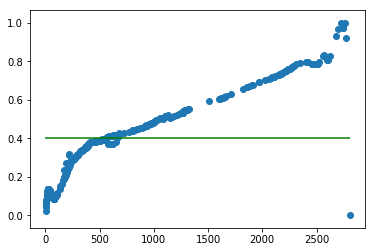

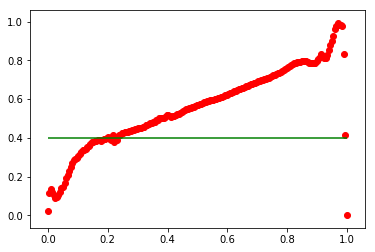

----------------------


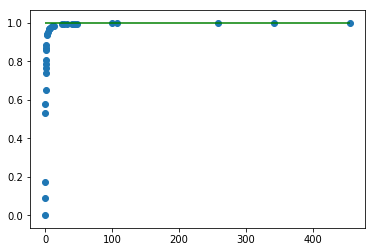

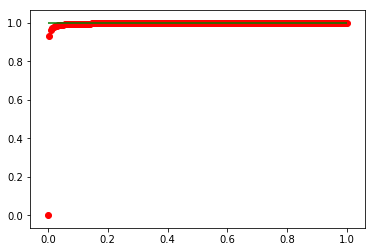

----------------------


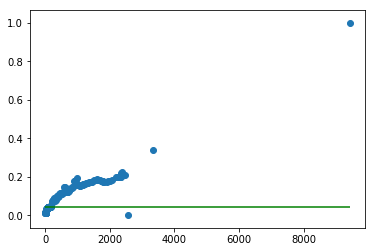

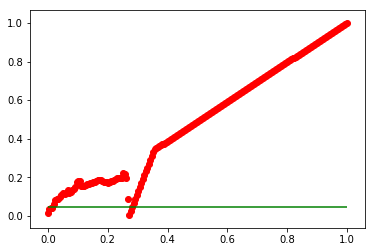

----------------------


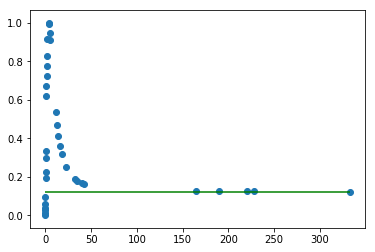

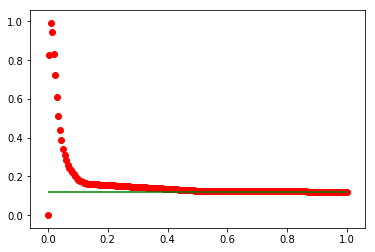

----------------------


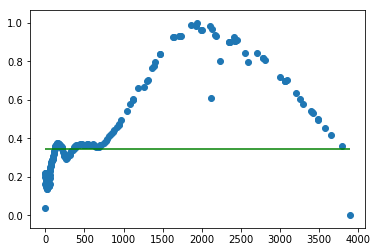

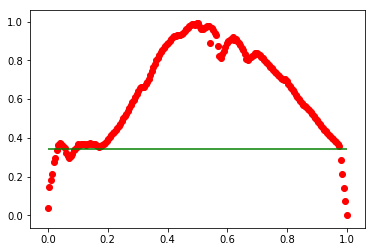

----------------------


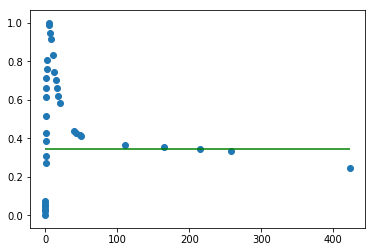

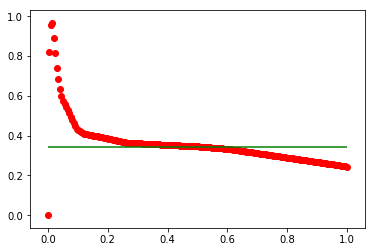

----------------------


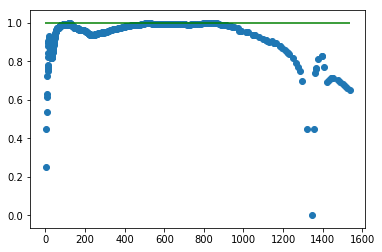

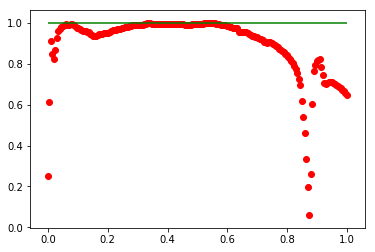

----------------------


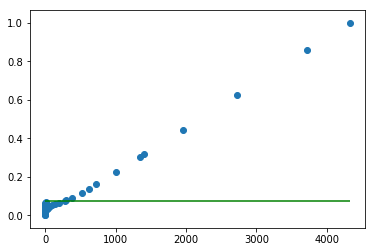

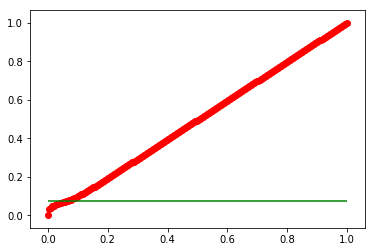

----------------------


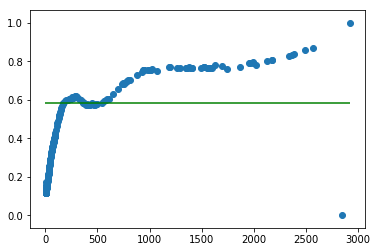

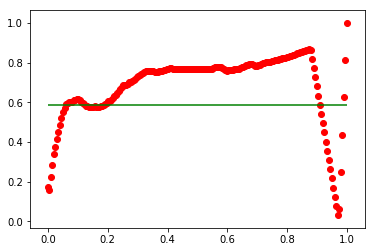

----------------------


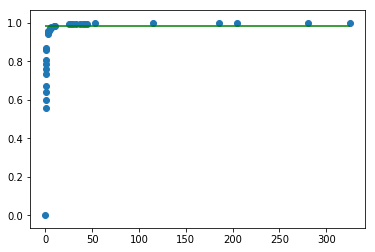

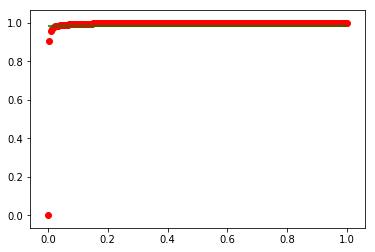

----------------------


In [738]:
for i in range(10):
    btch = (load_ppl << ds).next_batch(2)
    plt.scatter(btch.time[0], btch.derivative[0])
    plt.hlines(btch.target[0], 0, np.max(btch.time[0]), colors='g')
    plt.show()

#     plt.scatter(btch.norm_time[0], btch.derivative[0])
    plt.scatter(btch.time_grid[0], btch.derivative_grid[0], c='r')
    plt.hlines(btch.target[0], 0, 1, colors='g')
    plt.show()
    print('----------------------')

In [739]:
btch.target.shape

(2, 1)

In [1253]:
model_config={'inputs': dict(signals={'shape': (GRID_SIZE, 1)},
                             labels={'shape': (1, ), 'name': 'targets'}),
              'body': dict(layout='cnacna', kernel_size=[20, 20], filters=[10, 10]),
              'head': dict(layout='fa', units=1),
              'initial_block/inputs': 'signals',
              'loss': 'mse',
              'optimizer': ('MomentumOptimizer', {'learning_rate': 0.001, 'momentum': 0.5}),
             }

In [1257]:
ds.split(0.9)
len(ds.train.indices)

500

In [1291]:
train_template = (load_ppl
                  .init_variable('loss', init_on_each_run=0)
                  .init_variable('predictions', init_on_each_run=0)
                  .init_variable('saved_targets', init_on_each_run=0)
                  .init_variable('saved_indices', init_on_each_run=0)
                  .init_model('static', TFModel, 'baseline', config=model_config)
                  .train_model('baseline', fetches=['loss', 'predictions'],
                               feed_dict={'signals': B('derivative_grid'),
                                          'labels': B('target')},
                               save_to=[V('loss'), V('predictions')], mode='w')
                  .update_variable('saved_targets', B('target'))
                  .update_variable('saved_indices', B('indices'))
                 ) << ds.train

test_template = (load_ppl
                  .init_variable('loss', init_on_each_run=0)
                  .init_variable('predictions', init_on_each_run=0)
                  .init_variable('saved_targets', init_on_each_run=0)
                  .init_variable('saved_indices', init_on_each_run=0)
                  .import_model('baseline', train_template)
                  .predict_model('baseline', fetches=['loss', 'predictions'],
                               feed_dict={'signals': B('derivative_grid'),
                                          'labels': B('target')}, 
                                        save_to=[V('loss'), V('predictions')], mode='w')
                  .update_variable('saved_targets', B('target'))
                  .update_variable('saved_indices', B('indices'))
                ) << ds.test

In [1292]:
train_loss = []
test_loss = []

all_targets = []
all_predictions = []
all_indices = []

test_targets = []
test_predictions = []
test_indices = []

In [1293]:
for i in tqdm(range(1000)):
    btch = train_template.next_batch(20, shuffle=True, n_epochs=None, drop_last=True)
    train_loss.append(train_template.get_variable('loss'))
    all_targets.append(train_template.get_variable('saved_targets'))
    all_predictions.append(train_template.get_variable('predictions'))
    all_indices.append(train_template.get_variable('saved_indices'))
    if i % 10 == 0:
        btch = test_template.next_batch(60, shuffle=True, n_epochs=None)
        test_loss.append(test_template.get_variable('loss'))
        test_targets.append(test_template.get_variable('saved_targets'))
        test_predictions.append(test_template.get_variable('predictions'))
        test_indices.append(test_template.get_variable('saved_indices'))

В качестве proof of concept переобучимся на сабсете

** потерянный график лосса

Работает! а теперь обучимся на большей части и провалидируемся на тесте:

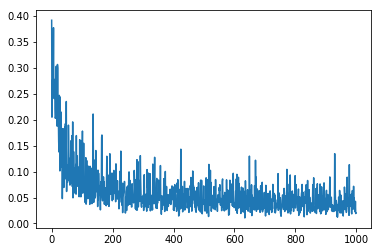

In [1294]:
plt.plot(train_loss)

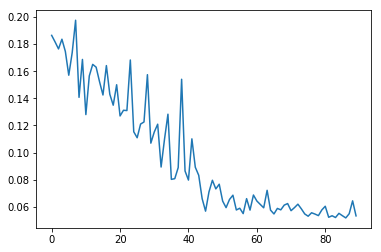

In [1299]:
plt.plot(test_loss[-90:])

# Посмотрим на результаты

In [1296]:
btch = test_template.next_batch(60, shuffle=True, n_epochs=None)
test_loss.append(test_template.get_variable('loss'))
test_targets.append(test_template.get_variable('saved_targets'))
test_predictions.append(test_template.get_variable('predictions'))
test_indices.append(test_template.get_variable('saved_indices'))

In [1297]:
predictions = test_predictions[-1]
targets = test_targets[-1]
btch.derivative_grid.shape


(55, 200, 1)

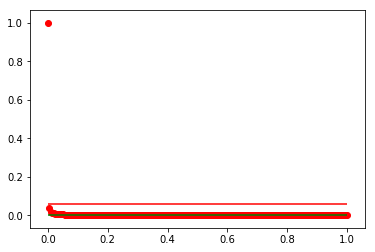

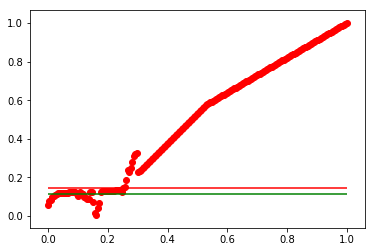

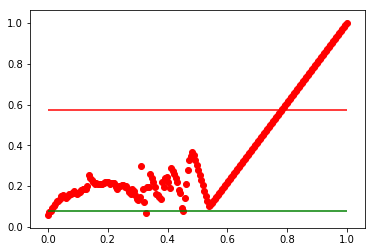

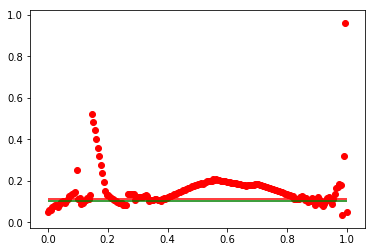

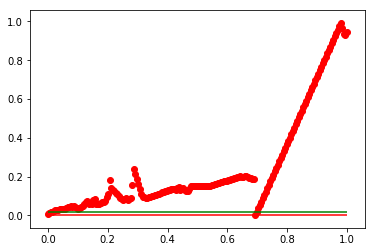

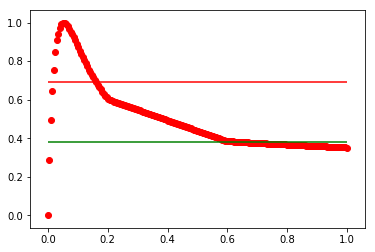

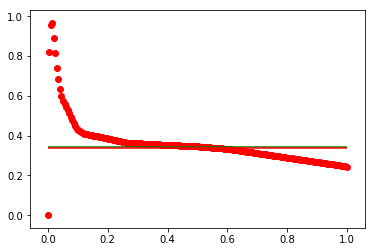

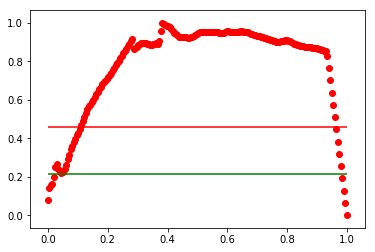

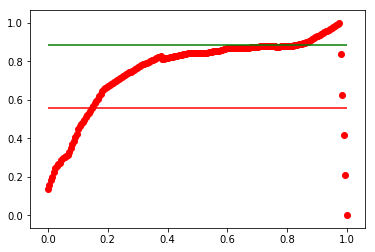

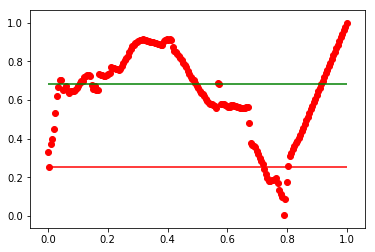

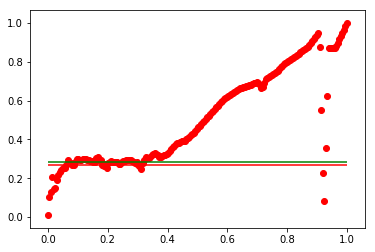

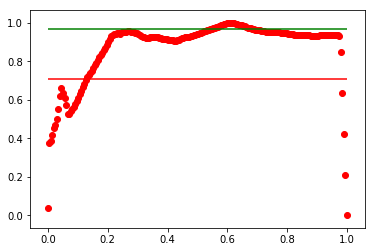

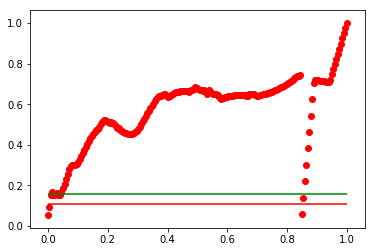

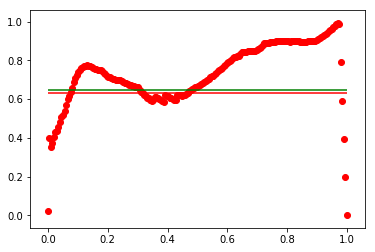

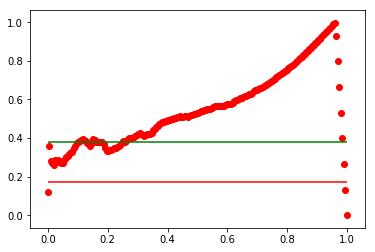

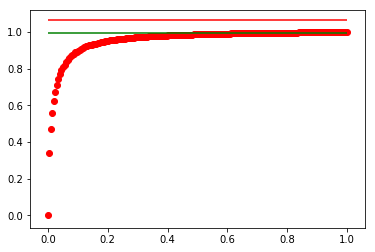

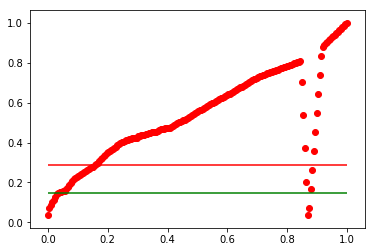

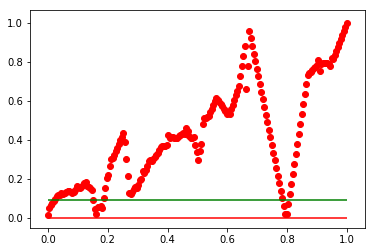

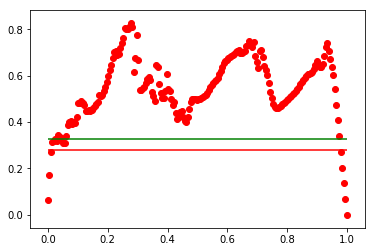

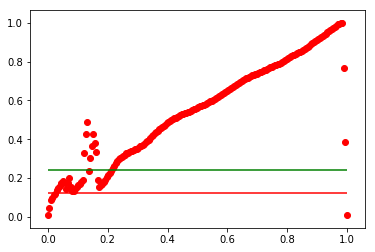

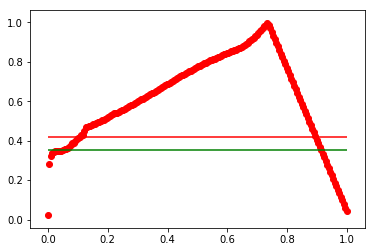

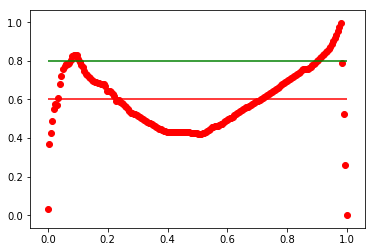

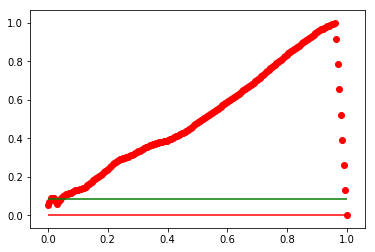

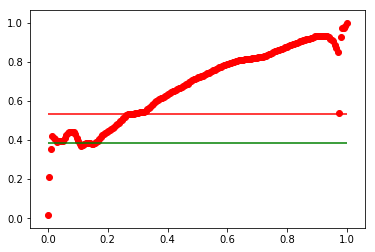

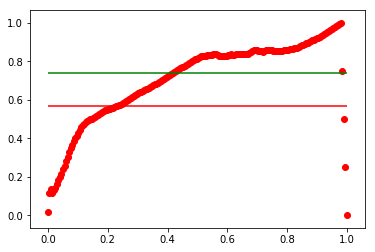

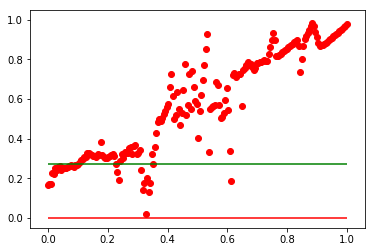

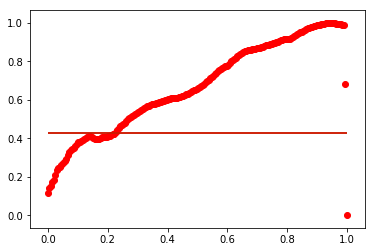

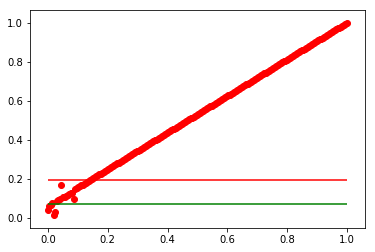

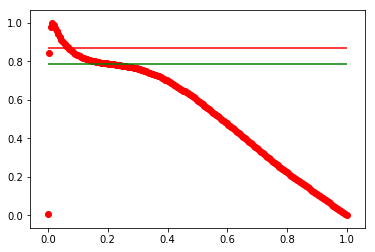

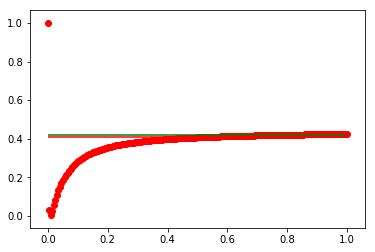

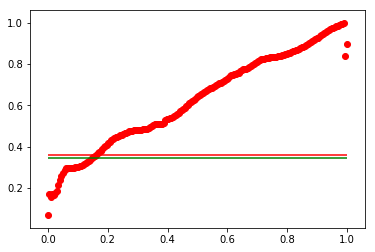

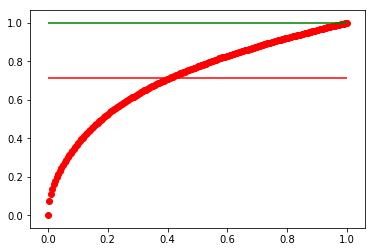

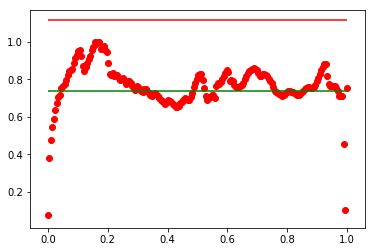

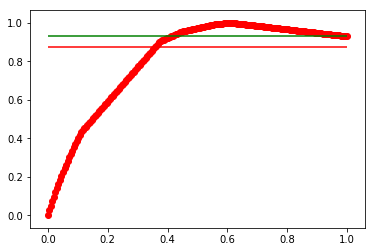

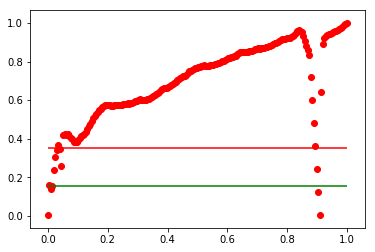

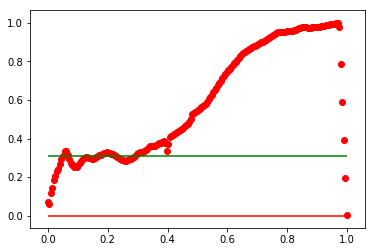

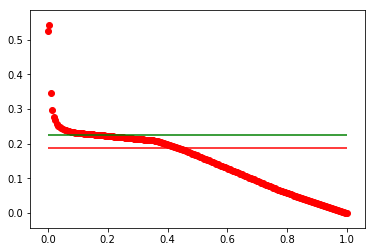

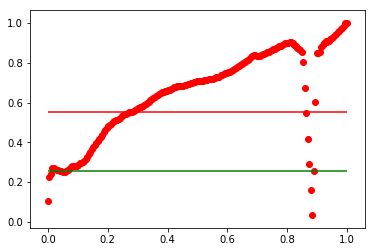

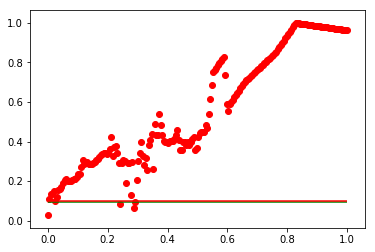

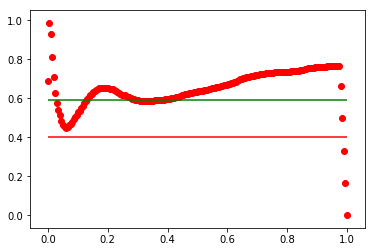

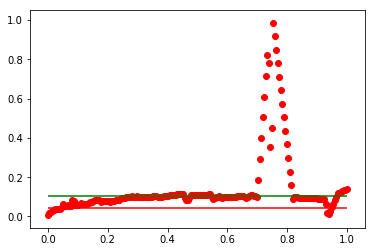

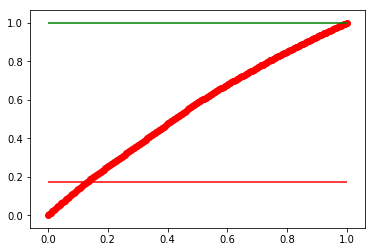

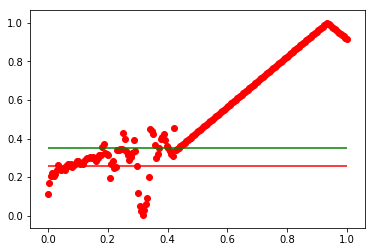

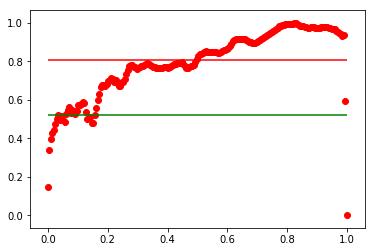

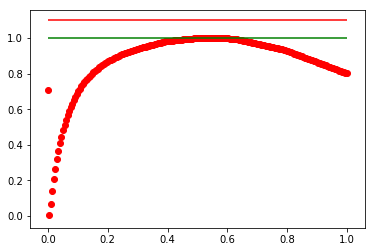

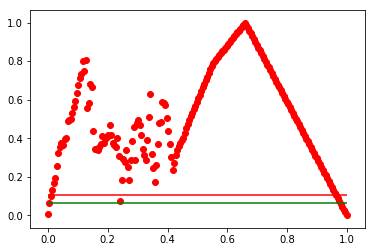

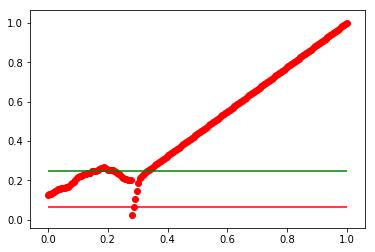

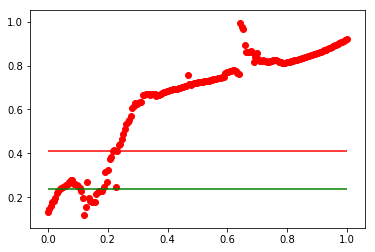

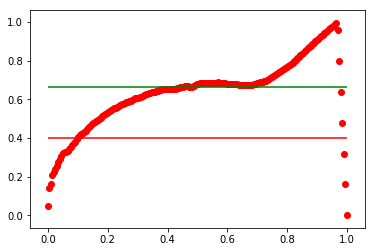

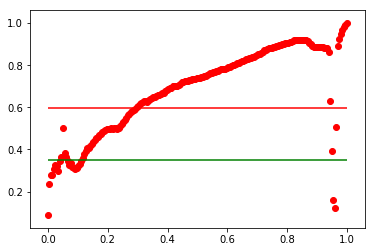

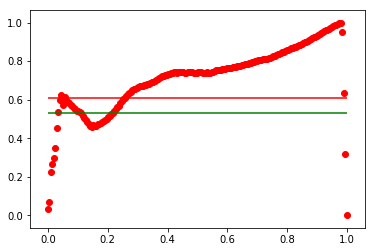

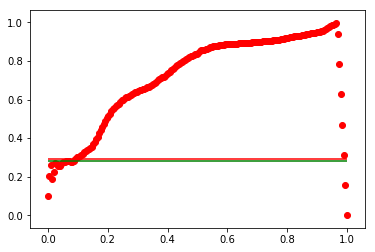

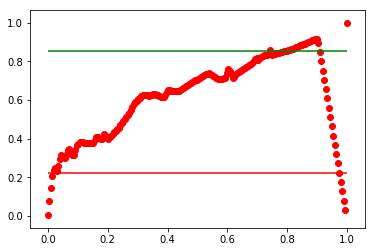

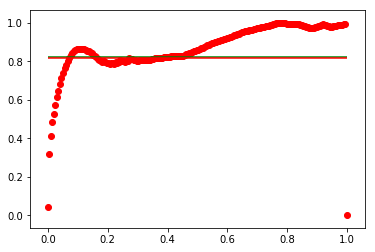

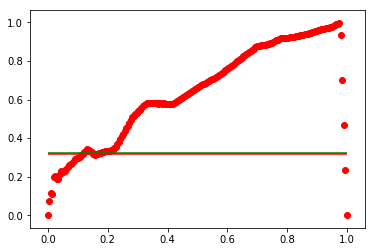

In [1298]:
for i in range(55):
    plt.scatter(btch.time_grid[i], btch.derivative_grid[i], c='r')
    plt.hlines(targets[i], 0, 1, colors='g')
    plt.hlines(predictions[i], 0, 1, colors='r')
    plt.show()

##  Далее следует локальный дебагинг, неинтересно

In [1147]:
train_loss[-15:]

[0.2593169,
 0.2627294,
 0.11999564,
 0.19147924,
 0.15762618,
 0.18468106,
 0.12243712,
 0.15933208,
 0.13128659,
 0.06833594,
 0.19000937,
 0.11500261,
 0.14454183,
 0.10502215,
 0.14836302]

In [1127]:
all_predictions[-15:][5]

array([[0.        ],
       [0.3784561 ],
       [0.        ],
       [1.2240001 ],
       [0.        ],
       [0.9227479 ],
       [1.133392  ],
       [0.        ],
       [0.06766126],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.3784561 ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.96348584],
       [0.6222197 ]], dtype=float32)

In [1128]:
all_targets[-15:][5]

array([[7.37904230e+01],
       [5.01187234e+01],
       [1.59969257e-02],
       [9.85768816e-01],
       [5.12861384e+02],
       [9.98942645e-01],
       [2.04838565e-01],
       [4.64369725e-01],
       [4.08797116e-01],
       [9.99943206e-01],
       [8.76180196e-02],
       [7.41682700e-03],
       [5.20587839e-01],
       [1.26299447e-01],
       [4.73413358e-01],
       [1.90675093e-01],
       [2.59608752e-01],
       [3.69367893e-01],
       [1.00783377e+00],
       [2.76554796e-01]])

In [1129]:
np.mean((all_predictions[-15:][5] - all_targets[-15:][5])**2)

13547.440323779321

In [1138]:
len(set(all_indices[-15:][5])) == len(all_indices[-15:][5])

False

In [1243]:
all_2 = np.array(['rr_8', 'rr_320', 'rr_315', 'sv_6', 'rr_77', 'sg_6', 'rr_220',
       'rr_199', 'rr_75', 'sv_20', 'rr_8', 'rr_151', 'rr_320', 'rr_156',
       'rr_77', 'rr_141', 'sv_5', 'rr_189', 'rr_288', 'rr_375'],
      dtype='<U20') 

In [1139]:
all_indices[-15:][5]

array(['rr_8', 'rr_320', 'rr_315', 'sv_6', 'rr_77', 'sg_6', 'rr_220',
       'rr_199', 'rr_75', 'sv_20', 'rr_8', 'rr_151', 'rr_320', 'rr_156',
       'rr_77', 'rr_141', 'sv_5', 'rr_189', 'rr_288', 'rr_375'],
      dtype='<U20')

index  0 ['rr_8']
target  0 [[0.08761802]]


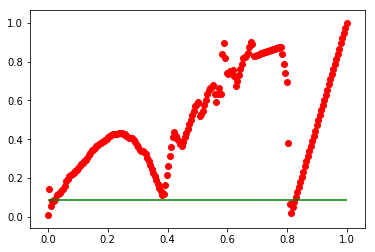

index  1 ['rr_320']
target  1 [[0.52058784]]


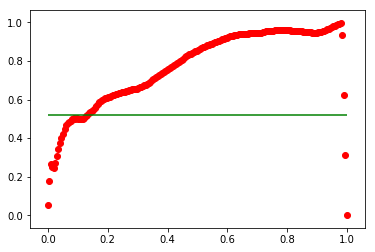

index  2 ['rr_315']
target  2 [[0.01599693]]


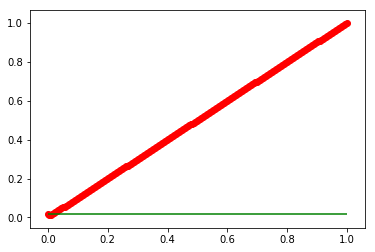

index  3 ['sv_6']
target  3 [[0.98576882]]


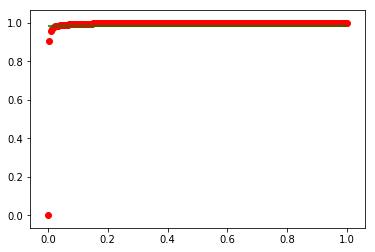

index  4 ['rr_77']
target  4 [[0.47341336]]


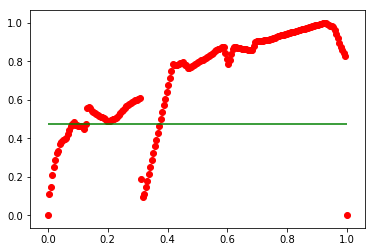

index  5 ['sg_6']
target  5 [[0.99894265]]


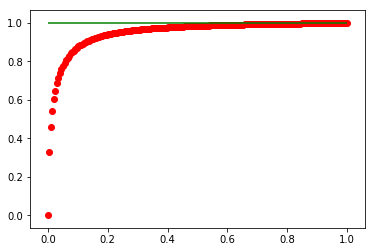

index  6 ['rr_220']
target  6 [[0.20483856]]


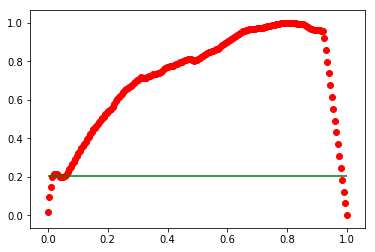

index  7 ['rr_199']
target  7 [[0.46436973]]


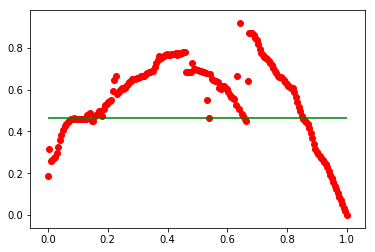

index  8 ['rr_75']
target  8 [[0.40879712]]


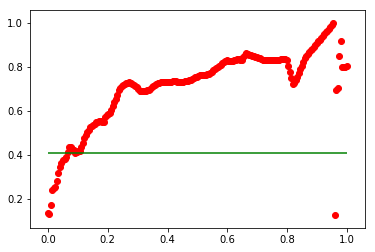

index  9 ['sv_20']
target  9 [[0.99994321]]


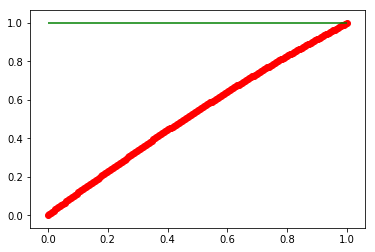

index  10 ['rr_8']
target  10 [[0.08761802]]


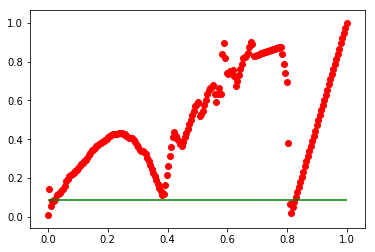

index  11 ['rr_151']
target  11 [[0.00741683]]


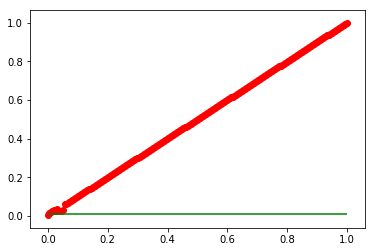

index  12 ['rr_320']
target  12 [[0.52058784]]


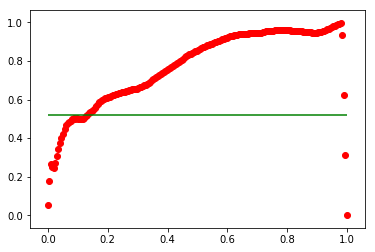

index  13 ['rr_156']
target  13 [[0.12629945]]


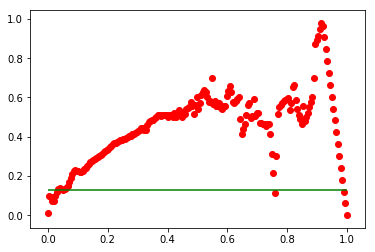

index  14 ['rr_77']
target  14 [[0.47341336]]


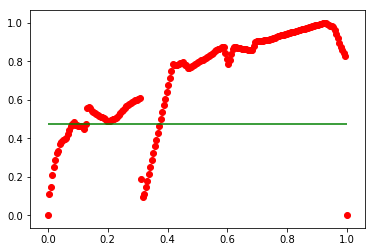

index  15 ['rr_141']
target  15 [[0.19067509]]


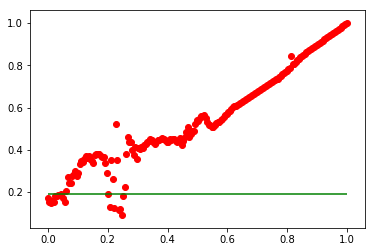

index  16 ['sv_5']
target  16 [[0.25960875]]


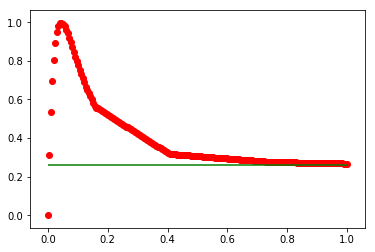

index  17 ['rr_189']
target  17 [[0.36936789]]


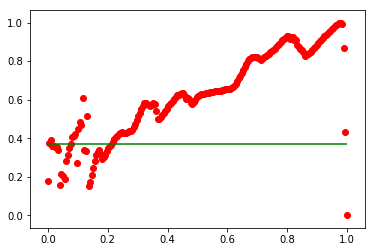

index  18 ['rr_288']
target  18 [[1.00783377]]


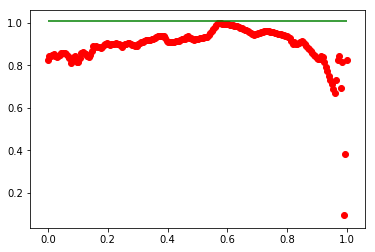

index  19 ['rr_375']
target  19 [[0.2765548]]


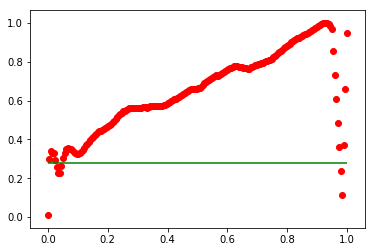

In [1246]:
for i, file_name in enumerate(all_2):
    path = 'npz/' + file_name + '.npz'
    index = FilesIndex(path=path, no_ext=True)
    ds_test = Dataset(index, batch_class=TmpBatch)
    btch = (load_ppl << ds_test).next_batch(1)
    print('index ', i, btch.indices)
    print('target ', i, btch.target)
    plt.scatter(btch.time_grid[0], btch.derivative_grid[0], c='r')
    plt.hlines(btch.target[0], 0, 1, colors='g')
    plt.show()

target  0 [[0.32600559]]


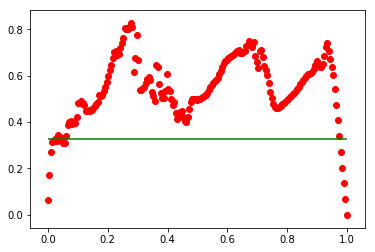

target  1 [[0.52058784]]


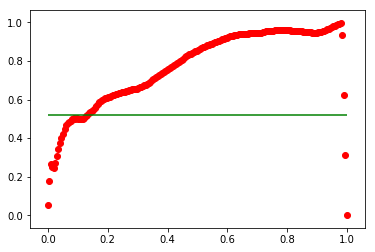

target  2 [[0.01599693]]


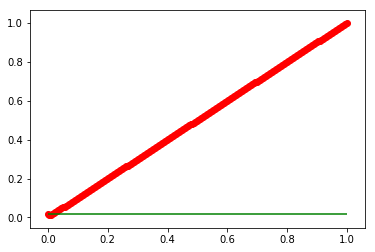

target  3 [[0.15316156]]


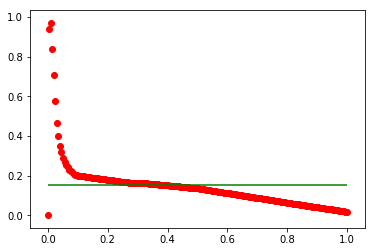

target  4 [[0.47341336]]


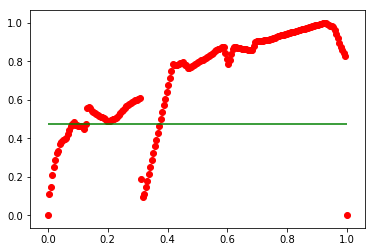

target  5 [[0.99898864]]


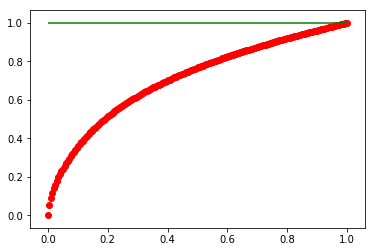

target  6 [[0.20483856]]


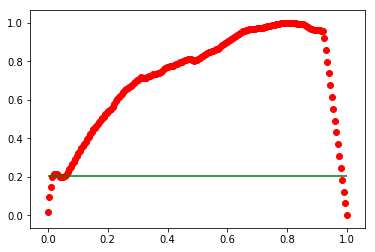

target  7 [[0.46436973]]


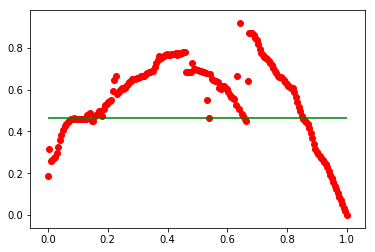

target  8 [[0.40879712]]


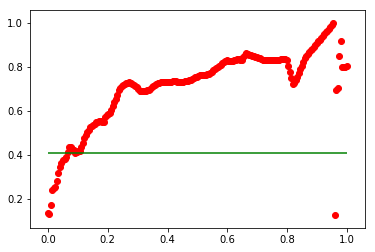

target  9 [[0.99994321]]


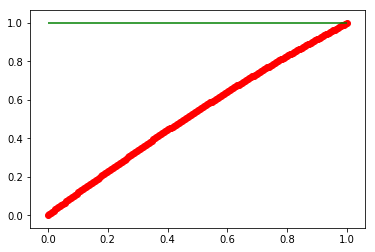

target  10 [[0.58718473]]


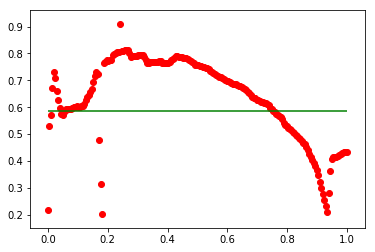

target  11 [[0.00741683]]


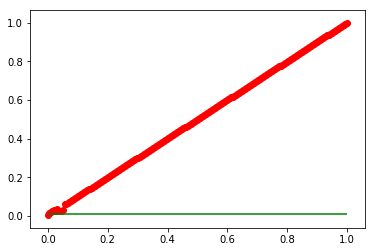

target  12 [[0.52058784]]


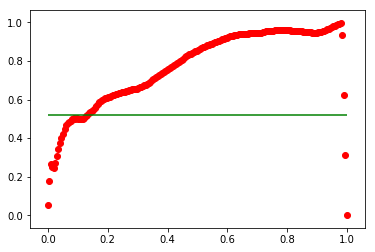

target  13 [[0.12629945]]


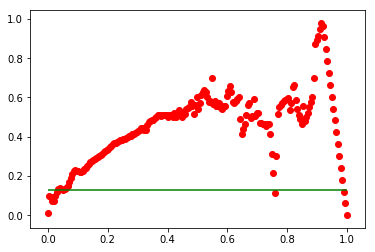

target  14 [[0.47341336]]


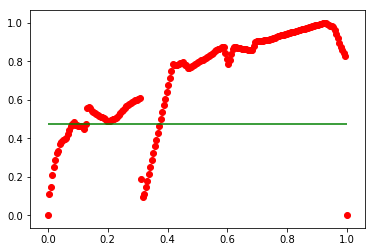

target  15 [[0.19067509]]


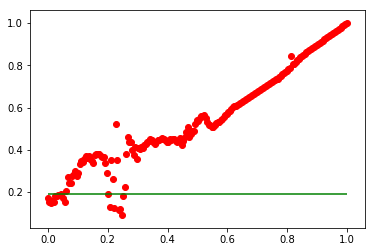

target  16 [[0.0365297]]


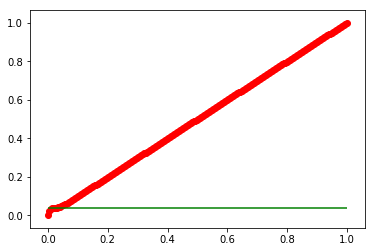

target  17 [[0.36936789]]


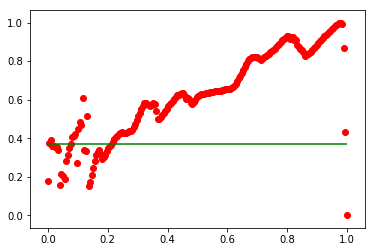

target  18 [[1.00783377]]


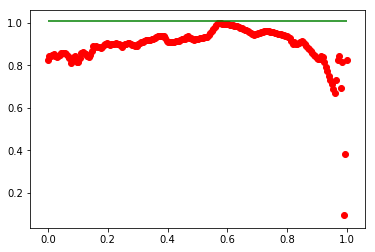

target  19 [[0.2765548]]


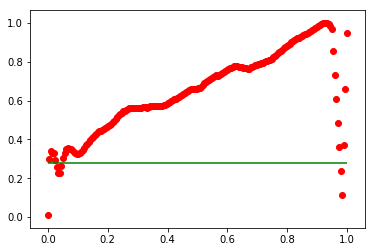

In [1135]:
for i, file_name in enumerate(all_indices[-15:][5]):
    path = 'npz/' + file_name + '*.npz'
    index = FilesIndex(path=path, no_ext=True)
    ds_test = Dataset(index, batch_class=TmpBatch)
    btch = (load_ppl << ds_test).next_batch(1)
    print('target ', i, btch.target)
    plt.scatter(btch.time_grid[0], btch.derivative_grid[0], c='r')
    plt.hlines(btch.target[0], 0, 1, colors='g')
    plt.show()

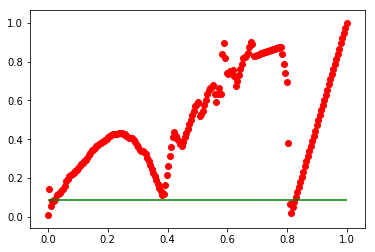

target  [0.08761802]
(258,)
[list([0.0, 842.183187485686])]
derivative range 1.0 0.0


In [1247]:
path = 'npz/' + 'rr_8' + '.npz'
index = FilesIndex(path=path, no_ext=True)
ds_test = Dataset(index, batch_class=TmpBatch)
btch = (load_ppl << ds_test).next_batch(1)

plt.scatter(btch.time_grid[0], btch.derivative_grid[0], c='r')
plt.hlines(btch.target[0], 0, 1, colors='g')
plt.show()

print('target ', btch.target[0])
print(btch.derivative[0].shape)
print(btch.derivative_range)
print('derivative range', np.max(btch.derivative[0]), np.min(btch.derivative[0]))

In [1230]:
0.0876 / 842

0.00010403800475059382

## Несовпадения наблюдаются только в тех индексах, которые встречаются повторно! из чего делаем вывод, что возможно, мы обработали дважды обработали загруженные данные ... возможно